# Modeling

## Initialisation

In [ ]:
# Main libs
import numpy as np
import pandas as pd
import optuna

# Modeling and evaluation
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

# System environment optimisation tools 
import itertools
import time
import gc

# Additional environment optimisation tools
from tqdm import notebook
from time import sleep

# Visualisation
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt


from pathlib import Path
import sys
ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import Config

In [3]:
config = Config()

In [4]:
full_df = pd.read_parquet(config.get('features'), engine='pyarrow')

### Continue

In [5]:
full_df.isna().sum().sum()

0

In [6]:
full_df.tail(5)

,date_block_num,shop_id,item_id,target,item_category_id,general_item_category_name,city,item_id_was_in_test,shop_id_was_in_test,not_full_historical_data,...,target_item_category_id_total_predict_1_2,target_item_category_id_total_predict_2_3,target_general_item_category_name_total_delta_1_2,target_general_item_category_name_total_delta_2_3,target_general_item_category_name_total_predict_1_2,target_general_item_category_name_total_predict_2_3,target_city_total_delta_1_2,target_city_total_delta_2_3,target_city_total_predict_1_2,target_city_total_predict_2_3
11027056,34,45,18454,0.0,55,9,20,1,1,0,...,6719.0,11427.0,720.0,-862.0,7548.0,13514.0,61.0,-65.0,1520.0,2914.0
11027057,34,45,16188,0.0,64,10,20,1,1,0,...,949.0,2625.0,3215.0,10414.0,16844.0,40887.0,61.0,1398.0,1520.0,4377.0
11027058,34,45,15757,0.0,55,9,20,1,1,0,...,6719.0,11427.0,720.0,-862.0,7548.0,13514.0,61.0,-65.0,1520.0,2914.0
11027059,34,45,19648,0.0,40,7,20,1,1,0,...,8562.0,14497.0,1674.0,-1910.0,14557.0,25530.0,61.0,-65.0,1520.0,2914.0
11027060,34,45,969,0.0,37,7,20,1,1,0,...,4854.0,8339.0,1674.0,-1910.0,14557.0,25530.0,61.0,-65.0,1520.0,2914.0


## Base predict

In [11]:
full_df['target_lag_1']

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
11027056    1.0
11027057    0.0
11027058    0.0
11027059    0.0
11027060    0.0
Name: target_lag_1, Length: 11027061, dtype: float32

In [6]:
train = full_df[full_df['date_block_num'] < 34]
train_x = train.drop('target', axis=1)
train_y = train['target']

test = full_df[full_df['date_block_num'] == 34]
test_x = test.drop('target', axis=1)

model = xgb.XGBRegressor()
model.fit(train_x, train_y)
y_pred = model.predict(test_x)

In [7]:
y_pred.shape


(214200,)

array([[<Axes: title={'center': '0'}>]], dtype=object)

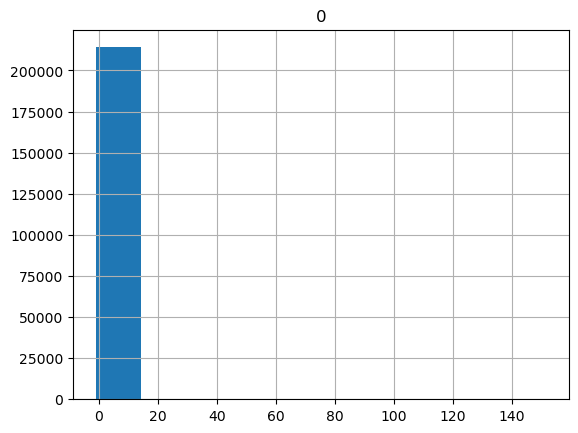

In [8]:
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.hist()


In [9]:
df_y_pred

,0
0,0.242725
1,0.422021
2,0.751039
3,0.263970
4,3.681005
...,...
214195,0.166719
214196,0.019705
214197,0.056225
214198,0.037302


In [18]:
y_pred = np.round(y_pred).astype(int)
y_pred = np.clip(y_pred, 0, None)
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['item_cnt_month']

df_y_pred['ID'] = df_y_pred.index
df_y_pred = df_y_pred[['ID','item_cnt_month']]
df_y_pred[df_y_pred['item_cnt_month'] > 0]

,ID,item_cnt_month
0,0,1
1,1,7
2,2,1
3,3,1
5,5,1
...,...,...
238049,238049,2
238050,238050,1
238060,238060,2
238064,238064,1


In [11]:
df_y_pred

,ID,item_cnt_month
0,0,0
1,1,0
2,2,1
3,3,0
4,4,4
...,...,...
214195,214195,0
214196,214196,0
214197,214197,0
214198,214198,0


In [12]:
df_y_pred.to_csv(config.get('predict_base'), index=False)

In [14]:
df_y_pred = pd.read_csv(config.get('predict_base'))

In [15]:
df_y_pred

,ID,item_cnt_month
0,0,0
1,1,0
2,2,1
3,3,0
4,4,4
...,...,...
214195,214195,0
214196,214196,0
214197,214197,0
214198,214198,0


In [ ]:
# # Previous Super naiv prediction with data leakege features:
# # MSE: 0.2597616
# # RMSE: 0.5096681
train = full_df[full_df['date_block_num'] < 33]
train_x = train.drop('target', axis=1)
train_y = train['target']

test = full_df[full_df['date_block_num'] == 33]
test_x = test.drop('target', axis=1)
test_y = test['target']

model = xgb.XGBRegressor()
model.fit(train_x, train_y)

y_pred = model.predict(test_x)
mse = mean_squared_error(test_y, y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 1.022863
RMSE: 1.011367


## Hyperparameters

In [19]:
train = full_df[full_df['date_block_num'] < 32]
train_x = train.drop('target', axis=1)
train_y = train['target']

validation = full_df[full_df['date_block_num'] == 32]
validation_x = validation.drop('target', axis=1)
validation_y = validation['target']

test = full_df[full_df['date_block_num'] == 33]
test_x = test.drop('target', axis=1)
test_y = test['target']

predict_for = full_df[full_df['date_block_num'] == 34].drop('target', axis = 1)

In [21]:
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
    }

    model = xgb.XGBRegressor(**param)
    model.fit(train_x, train_y, eval_set=[(validation_x, validation_y)], verbose=False)

    preds = model.predict(predict_for)
    rmse = root_mean_squared_error(test_y, preds)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)
#, early_stopping_rounds=20,

[I 2025-07-08 14:04:37,362] A new study created in memory with name: no-name-89b05819-d483-4741-bc4a-54ab1aa49d3c
[W 2025-07-08 14:08:28,095] Trial 0 failed with parameters: {'n_estimators': 299, 'max_depth': 7, 'learning_rate': 0.015776299744375485, 'subsample': 0.9876808926104572, 'colsample_bytree': 0.6077171750676542, 'gamma': 1.932357052409197, 'lambda': 6.875115783117061, 'alpha': 0.18142553862405036} because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [238084, 214200]').
Traceback (most recent call last):
  File "c:\Anaconda\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Мариан\AppData\Local\Temp\ipykernel_32220\1099543670.py", line 20, in objective
    rmse = root_mean_squared_error(test_y, preds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", 

ValueError: Found input variables with inconsistent numbers of samples: [238084, 214200]

In [ ]:
# Estimation based on 33d month validation, has data leakege due to aggegated data for month sales, should remove it and run again.  
# [I 2025-07-03 00:40:59,550] A new study created in memory with name: no-name-307d3ecb-8ef9-4b95-b149-8bbfab958e65
# [I 2025-07-03 00:45:50,837] Trial 0 finished with value: 1.2122911214828491 and parameters: {'n_estimators': 289, 'max_depth': 7, 'learning_rate': 0.001100285310823546, 'subsample': 0.6446032047402942, 'colsample_bytree': 0.5792823069099833, 'gamma': 3.7421572721250778, 'lambda': 0.07841983346696516, 'alpha': 0.02455771822928549}. Best is trial 0 with value: 1.2122911214828491.
# [I 2025-07-03 00:46:39,040] Trial 1 finished with value: 1.0205885171890259 and parameters: {'n_estimators': 51, 'max_depth': 3, 'learning_rate': 0.013327304801959048, 'subsample': 0.6123295203829673, 'colsample_bytree': 0.5159280348076186, 'gamma': 1.4834851521288528, 'lambda': 0.0016341497745920865, 'alpha': 0.01046386185305317}. Best is trial 1 with value: 1.0205885171890259.
# [I 2025-07-03 00:49:26,323] Trial 2 finished with value: 1.0453583002090454 and parameters: {'n_estimators': 174, 'max_depth': 9, 'learning_rate': 0.0028204833089940096, 'subsample': 0.602595867613839, 'colsample_bytree': 0.9968552587819393, 'gamma': 4.006470244823512, 'lambda': 0.03866095452856845, 'alpha': 5.933852055982097}. Best is trial 1 with value: 1.0205885171890259.
# [I 2025-07-03 00:51:20,708] Trial 3 finished with value: 0.6079909205436707 and parameters: {'n_estimators': 140, 'max_depth': 6, 'learning_rate': 0.015216050215719578, 'subsample': 0.7126061535870654, 'colsample_bytree': 0.6612407263317794, 'gamma': 2.9281514417190637, 'lambda': 0.08276841889536549, 'alpha': 0.007459654451448149}. Best is trial 3 with value: 0.6079909205436707.
# [I 2025-07-03 00:56:28,682] Trial 4 finished with value: 0.4744124710559845 and parameters: {'n_estimators': 277, 'max_depth': 11, 'learning_rate': 0.02205911976087848, 'subsample': 0.6735770603285217, 'colsample_bytree': 0.6653694486399042, 'gamma': 4.0737407818137585, 'lambda': 0.00849861450239712, 'alpha': 0.003206221469937861}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:01:07,048] Trial 5 finished with value: 1.170285940170288 and parameters: {'n_estimators': 284, 'max_depth': 11, 'learning_rate': 0.0011515324447841082, 'subsample': 0.9314035659180528, 'colsample_bytree': 0.9428768568432817, 'gamma': 1.0353555048315748, 'lambda': 0.054933696727225104, 'alpha': 5.362963044516505}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:02:53,181] Trial 6 finished with value: 0.7174256443977356 and parameters: {'n_estimators': 208, 'max_depth': 3, 'learning_rate': 0.00972165223451464, 'subsample': 0.8733124651612652, 'colsample_bytree': 0.8742778807842915, 'gamma': 4.49976744161982, 'lambda': 0.05875728814081001, 'alpha': 0.6764089962489653}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:06:03,307] Trial 7 finished with value: 0.4857695996761322 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.06894271291354717, 'subsample': 0.5883610279589717, 'colsample_bytree': 0.8327113680683871, 'gamma': 4.835489689469238, 'lambda': 0.24112014360591266, 'alpha': 0.0033222848225079563}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:09:22,436] Trial 8 finished with value: 0.540817379951477 and parameters: {'n_estimators': 194, 'max_depth': 11, 'learning_rate': 0.010891835350987481, 'subsample': 0.6818729113879447, 'colsample_bytree': 0.9380722331566396, 'gamma': 2.0194595758023133, 'lambda': 0.1555807257912952, 'alpha': 0.002087315554755367}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:12:08,649] Trial 9 finished with value: 1.1156154870986938 and parameters: {'n_estimators': 160, 'max_depth': 10, 'learning_rate': 0.0027125540206375124, 'subsample': 0.682590551423391, 'colsample_bytree': 0.5582276015754553, 'gamma': 0.6751928590916767, 'lambda': 0.14776080932540966, 'alpha': 0.002155377418028402}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:14:45,988] Trial 10 finished with value: 0.5159763693809509 and parameters: {'n_estimators': 238, 'max_depth': 12, 'learning_rate': 0.2522378893609467, 'subsample': 0.8186950925774304, 'colsample_bytree': 0.7207046043938155, 'gamma': 3.029461519298478, 'lambda': 4.99621487381476, 'alpha': 0.05463561220535147}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:17:37,733] Trial 11 finished with value: 0.48465776443481445 and parameters: {'n_estimators': 253, 'max_depth': 8, 'learning_rate': 0.08493219712264014, 'subsample': 0.5087113412220247, 'colsample_bytree': 0.8103149649365948, 'gamma': 4.915264880224221, 'lambda': 0.0048088110510724974, 'alpha': 0.0011162324223933661}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:20:03,370] Trial 12 finished with value: 0.4990231692790985 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.0578196251008231, 'subsample': 0.500779256073267, 'colsample_bytree': 0.776044070648098, 'gamma': 4.991597000767505, 'lambda': 0.00308548398376241, 'alpha': 0.0010363670644437507}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:22:16,111] Trial 13 finished with value: 0.5292173624038696 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.04400101296445195, 'subsample': 0.5054629872227894, 'colsample_bytree': 0.6535900167887915, 'gamma': 3.7927976682869846, 'lambda': 0.007742291967867247, 'alpha': 0.3019022524370428}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:23:50,284] Trial 14 finished with value: 0.48652657866477966 and parameters: {'n_estimators': 119, 'max_depth': 9, 'learning_rate': 0.16442569778833374, 'subsample': 0.7845409047445581, 'colsample_bytree': 0.7550422949657383, 'gamma': 4.184096914847799, 'lambda': 0.010417705204958199, 'alpha': 0.011498315924597309}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:28:21,428] Trial 15 finished with value: 0.47538691759109497 and parameters: {'n_estimators': 261, 'max_depth': 12, 'learning_rate': 0.03689687635135115, 'subsample': 0.5570694576488193, 'colsample_bytree': 0.6804932565694564, 'gamma': 3.20791890910606, 'lambda': 0.0115566474042481, 'alpha': 0.0590612695441673}. Best is trial 4 with value: 0.4744124710559845.
# [I 2025-07-03 01:32:30,170] Trial 16 finished with value: 0.4719689190387726 and parameters: {'n_estimators': 213, 'max_depth': 12, 'learning_rate': 0.029642621316836613, 'subsample': 0.5670082596017241, 'colsample_bytree': 0.6736613019887614, 'gamma': 2.9442233507017694, 'lambda': 0.013675375818867293, 'alpha': 0.20606687719533542}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 01:36:10,723] Trial 17 finished with value: 0.48059991002082825 and parameters: {'n_estimators': 213, 'max_depth': 10, 'learning_rate': 0.027181456811333823, 'subsample': 0.7479448900048905, 'colsample_bytree': 0.6173722827276206, 'gamma': 2.4195453544469423, 'lambda': 0.8348070970852444, 'alpha': 0.2787638750666886}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 01:38:36,746] Trial 18 finished with value: 1.0623424053192139 and parameters: {'n_estimators': 91, 'max_depth': 12, 'learning_rate': 0.005192029663273044, 'subsample': 0.9705688835848072, 'colsample_bytree': 0.7108043165607572, 'gamma': 3.434766817389111, 'lambda': 0.022653895554251617, 'alpha': 1.8082149946408508}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 01:45:12,044] Trial 19 finished with value: 0.48263663053512573 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.02203573174516194, 'subsample': 0.6511501623662832, 'colsample_bytree': 0.5086228849070848, 'gamma': 2.4228608022168716, 'lambda': 0.7720404361200126, 'alpha': 0.13251634125699197}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 01:48:40,395] Trial 20 finished with value: 0.4904053509235382 and parameters: {'n_estimators': 219, 'max_depth': 10, 'learning_rate': 0.11127083871952036, 'subsample': 0.5521631689106786, 'colsample_bytree': 0.6115339864747222, 'gamma': 2.0333222135013544, 'lambda': 0.0012336005067361785, 'alpha': 0.9125798827761675}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 01:54:06,142] Trial 21 finished with value: 0.4739447236061096 and parameters: {'n_estimators': 264, 'max_depth': 12, 'learning_rate': 0.034742101227054165, 'subsample': 0.5613162378118994, 'colsample_bytree': 0.6819345262248367, 'gamma': 3.171397609361632, 'lambda': 0.01315797215755273, 'alpha': 0.0490788126160595}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 01:59:48,959] Trial 22 finished with value: 0.47261738777160645 and parameters: {'n_estimators': 264, 'max_depth': 12, 'learning_rate': 0.027257692904201433, 'subsample': 0.5541432569401945, 'colsample_bytree': 0.7071720982237764, 'gamma': 2.8209984493198923, 'lambda': 0.02062558175061365, 'alpha': 0.023391173537437155}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 02:06:37,415] Trial 23 finished with value: 0.5794963836669922 and parameters: {'n_estimators': 266, 'max_depth': 12, 'learning_rate': 0.006626613421336072, 'subsample': 0.541163361503001, 'colsample_bytree': 0.7110841728281498, 'gamma': 2.6228983328013937, 'lambda': 0.020949615069552004, 'alpha': 0.026211223787571777}. Best is trial 16 with value: 0.4719689190387726.
# [I 2025-07-03 02:11:43,307] Trial 24 finished with value: 0.4716529846191406 and parameters: {'n_estimators': 193, 'max_depth': 12, 'learning_rate': 0.031553199009360766, 'subsample': 0.5865297259450369, 'colsample_bytree': 0.795240996371335, 'gamma': 0.021355834590766065, 'lambda': 0.022591850138769822, 'alpha': 0.13980552948469654}. Best is trial 24 with value: 0.4716529846191406.
# [I 2025-07-03 11:05:36,239] Trial 25 finished with value: 0.4711820185184479 and parameters: {'n_estimators': 192, 'max_depth': 10, 'learning_rate': 0.048582254563869796, 'subsample': 0.6181661020835687, 'colsample_bytree': 0.8044847344657655, 'gamma': 0.09138095272173441, 'lambda': 0.0033092436220839155, 'alpha': 0.18745339199183336}. Best is trial 25 with value: 0.4711820185184479.
# [I 2025-07-03 11:09:37,131] Trial 26 finished with value: 0.48509708046913147 and parameters: {'n_estimators': 188, 'max_depth': 9, 'learning_rate': 0.12621824571051676, 'subsample': 0.6168288461205698, 'colsample_bytree': 0.8499432232986485, 'gamma': 0.0763114558050038, 'lambda': 0.0028165278947636786, 'alpha': 0.1696464582269973}. Best is trial 25 with value: 0.4711820185184479.
# [I 2025-07-03 11:14:37,518] Trial 27 finished with value: 0.47541627287864685 and parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.05479251381471004, 'subsample': 0.7278380845018808, 'colsample_bytree': 0.7951922955657065, 'gamma': 0.0004544445271018327, 'lambda': 0.0039964855399717975, 'alpha': 0.47438645396424617}. Best is trial 25 with value: 0.4711820185184479.
# [I 2025-07-03 11:18:26,690] Trial 28 finished with value: 0.4852462410926819 and parameters: {'n_estimators': 193, 'max_depth': 11, 'learning_rate': 0.0916683732458291, 'subsample': 0.631902099435605, 'colsample_bytree': 0.8942540414686767, 'gamma': 0.49161652599471595, 'lambda': 0.0017432463889940101, 'alpha': 1.631192849303652}. Best is trial 25 with value: 0.4711820185184479.
# [I 2025-07-03 11:20:54,926] Trial 29 finished with value: 0.5052967667579651 and parameters: {'n_estimators': 139, 'max_depth': 10, 'learning_rate': 0.20326937498622866, 'subsample': 0.5883263596952141, 'colsample_bytree': 0.7435769547053013, 'gamma': 1.290524003063812, 'lambda': 0.031510888272170974, 'alpha': 0.2140294351142087}. Best is trial 25 with value: 0.4711820185184479.
# [I 2025-07-03 11:25:02,251] Trial 30 finished with value: 0.4796210527420044 and parameters: {'n_estimators': 178, 'max_depth': 11, 'learning_rate': 0.04223111105756623, 'subsample': 0.6408698920556006, 'colsample_bytree': 0.7673965392439743, 'gamma': 0.40444040880842436, 'lambda': 0.0050875115777889715, 'alpha': 0.09693048051646612}. Best is trial 25 with value: 0.4711820185184479.
# [I 2025-07-03 11:30:52,219] Trial 31 finished with value: 0.47029533982276917 and parameters: {'n_estimators': 236, 'max_depth': 12, 'learning_rate': 0.027490602345093963, 'subsample': 0.5357913603931805, 'colsample_bytree': 0.8153073895163945, 'gamma': 2.029936307022255, 'lambda': 0.019255079984299147, 'alpha': 0.10093603911432215}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:36:31,024] Trial 32 finished with value: 0.4813685417175293 and parameters: {'n_estimators': 232, 'max_depth': 12, 'learning_rate': 0.017418348528739927, 'subsample': 0.5872774796364306, 'colsample_bytree': 0.8224773605762566, 'gamma': 1.7320242278411946, 'lambda': 0.015804459996860407, 'alpha': 0.0904980491155101}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:40:41,679] Trial 33 finished with value: 0.4733392894268036 and parameters: {'n_estimators': 207, 'max_depth': 11, 'learning_rate': 0.029892748155319712, 'subsample': 0.5284609252543017, 'colsample_bytree': 0.8622107271454316, 'gamma': 0.8901712749955264, 'lambda': 0.030953387330567052, 'alpha': 0.46486264597406834}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:43:30,586] Trial 34 finished with value: 0.5094286799430847 and parameters: {'n_estimators': 167, 'max_depth': 9, 'learning_rate': 0.01822909274094088, 'subsample': 0.5794657505802852, 'colsample_bytree': 0.9016702327073917, 'gamma': 0.28421809933019804, 'lambda': 0.002055609904758034, 'alpha': 0.03175376807073893}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:48:54,142] Trial 35 finished with value: 0.5013414621353149 and parameters: {'n_estimators': 226, 'max_depth': 12, 'learning_rate': 0.012325380000994169, 'subsample': 0.6084000442960568, 'colsample_bytree': 0.7912354500404624, 'gamma': 1.520008343550519, 'lambda': 0.006343866908282777, 'alpha': 0.1150870817356393}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:50:28,834] Trial 36 finished with value: 0.5384595990180969 and parameters: {'n_estimators': 142, 'max_depth': 5, 'learning_rate': 0.05084361058650549, 'subsample': 0.661739847370922, 'colsample_bytree': 0.74004733281501, 'gamma': 0.7442619348953868, 'lambda': 0.0010099986195021883, 'alpha': 0.01512410253463105}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:51:42,873] Trial 37 finished with value: 0.4951586425304413 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.07150556547880411, 'subsample': 0.6958959872803399, 'colsample_bytree': 0.8352409947320127, 'gamma': 1.1195852425806552, 'lambda': 0.04406228504052351, 'alpha': 1.1375801027096437}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:54:48,269] Trial 38 finished with value: 0.6192284226417542 and parameters: {'n_estimators': 179, 'max_depth': 10, 'learning_rate': 0.008411332097788294, 'subsample': 0.5299979830816006, 'colsample_bytree': 0.9221540783386705, 'gamma': 3.5451321532415205, 'lambda': 0.09160419352605685, 'alpha': 0.5147395364181835}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 11:58:13,019] Trial 39 finished with value: 0.48203805088996887 and parameters: {'n_estimators': 196, 'max_depth': 11, 'learning_rate': 0.020663435568052405, 'subsample': 0.6235313668768048, 'colsample_bytree': 0.9674860440273201, 'gamma': 1.9746508544285724, 'lambda': 0.0685549242303106, 'alpha': 0.2678122855404028}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:01:55,768] Trial 40 finished with value: 0.5198640823364258 and parameters: {'n_estimators': 244, 'max_depth': 8, 'learning_rate': 0.013576810768026073, 'subsample': 0.5724985791112522, 'colsample_bytree': 0.6330058163056389, 'gamma': 2.2316326044724315, 'lambda': 0.45818643743336357, 'alpha': 3.368161513898018}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:06:42,965] Trial 41 finished with value: 0.4799596965312958 and parameters: {'n_estimators': 203, 'max_depth': 12, 'learning_rate': 0.025725817756244548, 'subsample': 0.5327678313484204, 'colsample_bytree': 0.5722951794138914, 'gamma': 2.7832957219678147, 'lambda': 0.019661660327339296, 'alpha': 0.0699829659004716}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:11:10,649] Trial 42 finished with value: 0.47351935505867004 and parameters: {'n_estimators': 220, 'max_depth': 12, 'learning_rate': 0.0322293783456669, 'subsample': 0.603744658957042, 'colsample_bytree': 0.7947635687919122, 'gamma': 2.7719879238668175, 'lambda': 0.008509233995749012, 'alpha': 0.03690745491909425}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:17:09,313] Trial 43 finished with value: 0.4813633859157562 and parameters: {'n_estimators': 274, 'max_depth': 11, 'learning_rate': 0.0151044851629801, 'subsample': 0.5630197670620373, 'colsample_bytree': 0.6962315446574807, 'gamma': 1.6777713327764416, 'lambda': 0.0348403736390115, 'alpha': 0.0064350278815750814}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:22:01,608] Trial 44 finished with value: 0.4768354296684265 and parameters: {'n_estimators': 236, 'max_depth': 12, 'learning_rate': 0.026038025180812184, 'subsample': 0.5189949174666282, 'colsample_bytree': 0.7346811505806494, 'gamma': 3.4586706780679695, 'lambda': 0.12289205352708273, 'alpha': 0.019504557168101278}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:27:13,848] Trial 45 finished with value: 0.4805871844291687 and parameters: {'n_estimators': 297, 'max_depth': 11, 'learning_rate': 0.06996286437048879, 'subsample': 0.8650477826708705, 'colsample_bytree': 0.7720357412001011, 'gamma': 0.6757446543127061, 'lambda': 0.04781645604334226, 'alpha': 0.12888086415915107}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:31:37,693] Trial 46 finished with value: 0.47812631726264954 and parameters: {'n_estimators': 184, 'max_depth': 12, 'learning_rate': 0.04290258044576102, 'subsample': 0.5955116730731296, 'colsample_bytree': 0.650867959042225, 'gamma': 0.28323634169865297, 'lambda': 0.015146424957184365, 'alpha': 0.008020451211570639}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:33:52,016] Trial 47 finished with value: 1.1626193523406982 and parameters: {'n_estimators': 253, 'max_depth': 3, 'learning_rate': 0.001666714105280204, 'subsample': 0.5420925835381901, 'colsample_bytree': 0.8169903785827939, 'gamma': 2.9343874434031667, 'lambda': 7.622381893309898, 'alpha': 0.1699175372984872}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:36:07,906] Trial 48 finished with value: 0.5174592137336731 and parameters: {'n_estimators': 204, 'max_depth': 6, 'learning_rate': 0.055285810157745356, 'subsample': 0.6600911505115483, 'colsample_bytree': 0.8523379232067585, 'gamma': 4.343107937543424, 'lambda': 0.002993480720098924, 'alpha': 0.3803902275475474}. Best is trial 31 with value: 0.47029533982276917.
# [I 2025-07-03 12:40:19,696] Trial 49 finished with value: 0.5550186038017273 and parameters: {'n_estimators': 244, 'max_depth': 9, 'learning_rate': 0.010048123134378192, 'subsample': 0.6326612117115705, 'colsample_bytree': 0.5477742213307578, 'gamma': 3.90011171627695, 'lambda': 0.007995406662843083, 'alpha': 0.06993016758693642}. Best is trial 31 with value: 0.47029533982276917.
# Best params: {'n_estimators': 236, 'max_depth': 12, 'learning_rate': 0.027490602345093963, 'subsample': 0.5357913603931805, 'colsample_bytree': 0.8153073895163945, 'gamma': 2.029936307022255, 'lambda': 0.019255079984299147, 'alpha': 0.10093603911432215}
# Best RMSE: 0.47029533982276917

### Training with hyperopt

In [ ]:
# train = full_df[full_df['date_block_num'] < 33]
# train_x = train.drop('target', axis=1)
# train_y = train['target']

# test = full_df[full_df['date_block_num'] == 33]
# test_x = test.drop('target', axis=1)
# test_y = test['target']

# model = xgb.XGBRegressor(**params)
# model.fit(train_x, train_y)

# y_pred = model.predict(test_x)
# mse = mean_squared_error(test_y, y_pred)
# print("MSE:", mse)

# rmse = np.sqrt(mse)
# print("RMSE:", rmse)

MSE: 1.022863
RMSE: 1.011367


In [ ]:
# df_y_pred.to_csv(config.get('predict'), index=False)

In [ ]:
params = {'n_estimators': 236, 'max_depth': 12, 'learning_rate':\
           0.027490602345093963, 'subsample': 0.5357913603931805,\
              'colsample_bytree': 0.8153073895163945, 'gamma': 2.029936307022255,\
                  'lambda': 0.019255079984299147, 'alpha': 0.10093603911432215
                  ,'tree_method': 'hist', 'device' : 'cuda', 'verbosity': 2}



train = full_df[full_df['date_block_num'] < 34]
train_x = train.drop('target', axis=1)
train_y = train['target']

test = full_df[full_df['date_block_num'] == 34]
test_x = test.drop('target', axis=1)


model = xgb.XGBRegressor(**params)
model.fit(train_x, train_y)




[17:59:18] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (10812861, 122, 1319169042).
[17:59:18] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


TypeError: DMatrix.__init__() got an unexpected keyword argument 'device'

In [28]:
dmatrix = xgb.DMatrix(data=test_x)
y_pred = model.predict(test_x)

In [31]:
y_pred

array([0.38394877, 0.31540197, 0.7831877 , ..., 0.07993777, 0.02964303,
       0.05912587], dtype=float32)

In [32]:
y_pred = np.clip(y_pred, 0, 20)
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['item_cnt_month']

df_y_pred['ID'] = df_y_pred.index
df_y_pred = df_y_pred[['ID','item_cnt_month']]
df_y_pred[df_y_pred['item_cnt_month'] > 0]

,ID,item_cnt_month
0,0,0.383949
1,1,0.315402
2,2,0.783188
3,3,0.312445
4,4,2.474624
...,...,...
214195,214195,0.183629
214196,214196,0.022839
214197,214197,0.079938
214198,214198,0.029643


In [34]:
df_y_pred.to_csv(config.get('predict'), index= False)

In [21]:
# Get feature importances
booster = model.get_booster()

# Importance types: "weight", "gain", "cover", "total_gain", "total_cover"
importance = booster.get_score(importance_type='gain')

# Convert to DataFrame for readability
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

importance_df['importance_precentage']= importance_df['Importance'] / importance_df['Importance'].sum()

In [ ]:
importance_df[0:50]

,Feature,Importance,importance_precentage
18,target_lag_1,18117.712891,0.229711
9,first_month_item_id,3503.678467,0.044422
101,target_predict_2_3,3300.994629,0.041853
52,target_aggregated_max_premonthes_item_id_lag_2,2413.709473,0.030603
44,target_item_category_id_mean_lag_2,2345.716064,0.029741
30,target_aggregated_max_premonthes_item_id_shop_...,1918.619263,0.024326
100,target_predict_1_2,1831.257690,0.023218
11,target_aggregated_max_premonthes_item_id_shop_id,1588.877563,0.020145
38,target_lag_2,1501.626221,0.019039
10,target_aggregated_mean_premonthes_item_id_shop_id,1458.317871,0.018490


Above here we can see that the most important feature is target_lag_1 and lags from expanding window aggregations as target_aggregated_max_premonthes_item_id_lag_2, target_aggregated_max_premonthes_item_id_shop_, target_aggregated_max_premonthes_item_id_shop_id. Not the less important: first_month_item_id it's a binary feature responsible for the fact item is selling first time in this month.

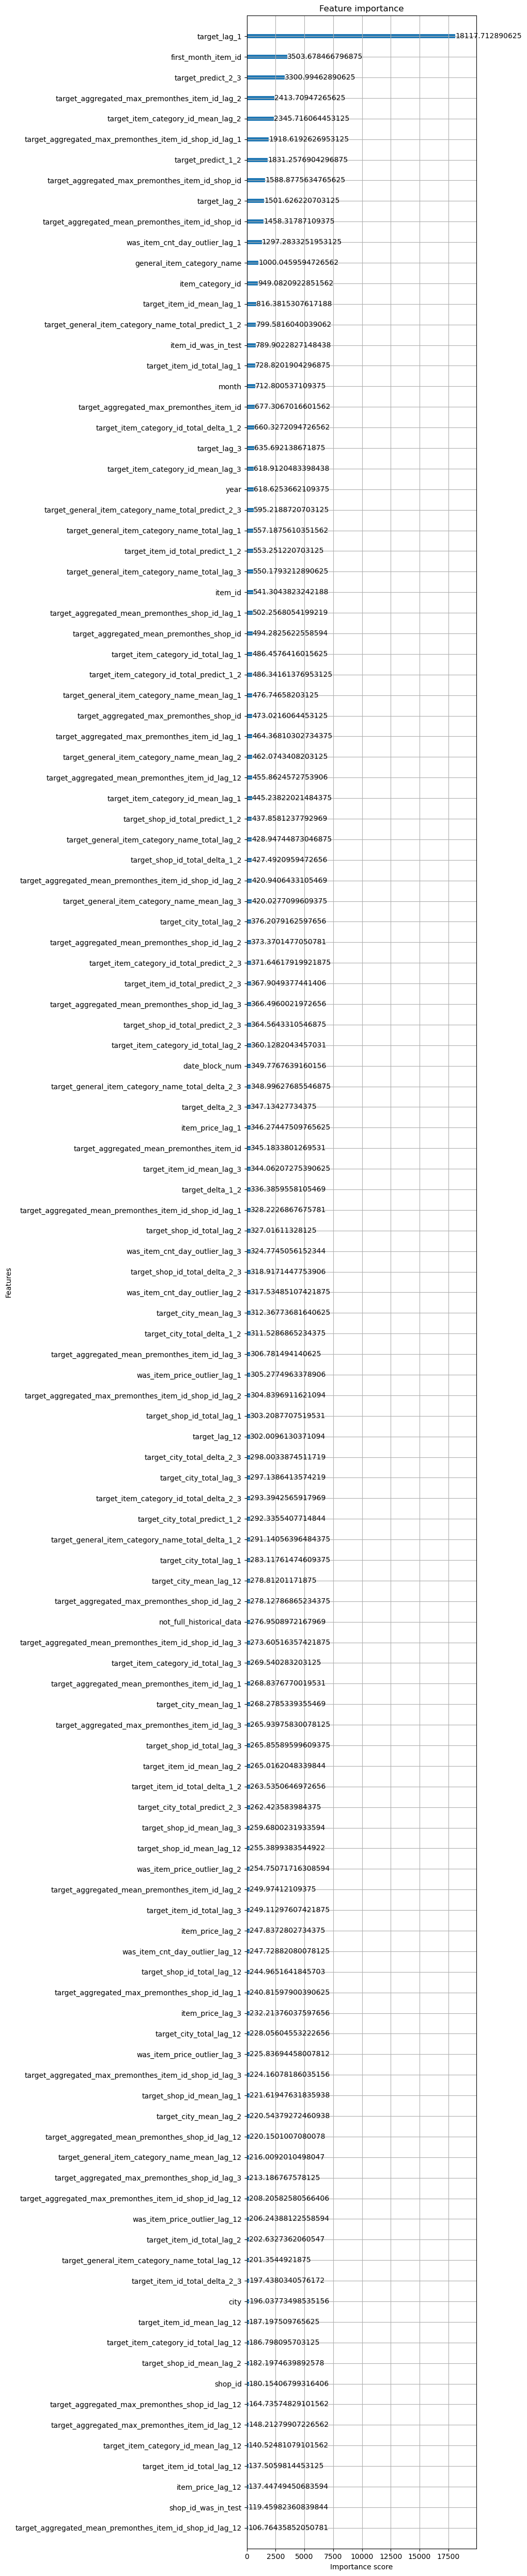

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 50))  
xgb.plot_importance(model, importance_type='gain', ax=ax)
plt.tight_layout()
plt.savefig("feature_importance.png")

In [ ]:
y_pred